In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, cross_val_score
from xgboost import XGBRegressor

/Users/alexrovnyak/Documents/r_d_course_ml_forecasting/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [2]:
# Load data
train = pd.read_csv("data/train.csv")
test = pd.read_csv("data/test.csv")
items = pd.read_csv("data/items.csv")
stores = pd.read_csv("data/stores.csv")
oil = pd.read_csv("data/oil.csv")
transactions = pd.read_csv("data/transactions.csv")
holidays = pd.read_csv("data/holidays_events.csv")


/var/folders/mg/hcjfqqxj19n3y9wkwzpkcnvw0000gn/T/ipykernel_6056/3707814969.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("data/train.csv")


In [3]:
#to do: print head of each dataframe 
dataframes = {
    "train": train,
    "test": test,
    "items": items,
    "stores": stores,
    "oil": oil,
    "transactions": transactions,
    "holidays": holidays
}

for name, df in dataframes.items():
    print(f"Head of {name} dataframe:")
    print(df.head())
    print()

Head of train dataframe:
   id        date  store_nbr  item_nbr  unit_sales onpromotion
0   0  2013-01-01         25    103665         7.0         NaN
1   1  2013-01-01         25    105574         1.0         NaN
2   2  2013-01-01         25    105575         2.0         NaN
3   3  2013-01-01         25    108079         1.0         NaN
4   4  2013-01-01         25    108701         1.0         NaN

Head of test dataframe:
          id        date  store_nbr  item_nbr  onpromotion
0  125497040  2017-08-16          1     96995        False
1  125497041  2017-08-16          1     99197        False
2  125497042  2017-08-16          1    103501        False
3  125497043  2017-08-16          1    103520        False
4  125497044  2017-08-16          1    103665        False

Head of items dataframe:
   item_nbr        family  class  perishable
0     96995     GROCERY I   1093           0
1     99197     GROCERY I   1067           0
2    103501      CLEANING   3008           0
3    103520 

In [4]:
# Convert to datetime
train["date"] = pd.to_datetime(train["date"])
test["date"] = pd.to_datetime(test["date"])
oil["date"] = pd.to_datetime(oil["date"])
transactions["date"] = pd.to_datetime(transactions["date"])
holidays["date"] = pd.to_datetime(holidays["date"])

In [5]:
def build_base_frame(df):
    """
    df: DataFrame with at least ['date', 'store_nbr', 'item_nbr', 'onpromotion']
        (works for both train and test-style frames)
    Returns: enriched DataFrame joined with items, stores, oil, transactions, holidays.
    """

    out = df.copy()

    # 1) Add item info (family, class, perishable)
    out = out.merge(items, on="item_nbr", how="left")

    # 2) Add store info (city, state, type, cluster)
    out = out.merge(stores, on="store_nbr", how="left")

    # 3) Add oil price
    out = out.merge(oil, on="date", how="left")


    # 5) Add simple holiday info by date
    #    (later we can refine with locale / city / state)
    out = out.merge(
        holidays[["date", "type", "locale", "locale_name", "description", "transferred"]],
        on="date",
        how="left"
    )

    return out

# Build merged dataset for train
train_full = build_base_frame(train)

# Quick sanity check
print(train_full.head())
print(train_full.shape)

   id       date  store_nbr  item_nbr  unit_sales onpromotion        family  \
0   0 2013-01-01         25    103665         7.0         NaN  BREAD/BAKERY   
1   1 2013-01-01         25    105574         1.0         NaN     GROCERY I   
2   2 2013-01-01         25    105575         2.0         NaN     GROCERY I   
3   3 2013-01-01         25    108079         1.0         NaN     GROCERY I   
4   4 2013-01-01         25    108701         1.0         NaN          DELI   

   class  perishable     city        state type_x  cluster  dcoilwtico  \
0   2712           1  Salinas  Santa Elena      D        1         NaN   
1   1045           0  Salinas  Santa Elena      D        1         NaN   
2   1045           0  Salinas  Santa Elena      D        1         NaN   
3   1030           0  Salinas  Santa Elena      D        1         NaN   
4   2644           1  Salinas  Santa Elena      D        1         NaN   

    type_y    locale locale_name         description transferred  
0  Holiday  N

In [6]:
print(train_full.shape)

(127970257, 19)


In [7]:

print("Min date in train:", train["date"].min())
print("Max date in train:", train["date"].max())

Min date in train: 2013-01-01 00:00:00
Max date in train: 2017-08-15 00:00:00


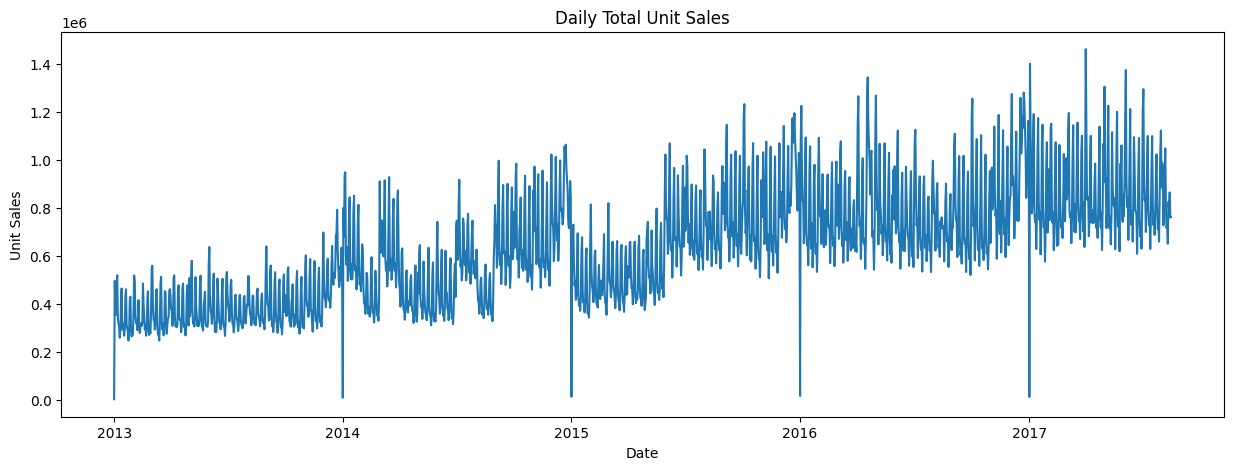

In [8]:
#to do: aggregate by day and plot time series 
daily_sales = train.groupby("date")["unit_sales"].sum().reset_index()
plt.figure(figsize=(15, 5))
plt.plot(daily_sales["date"], daily_sales["unit_sales"])
plt.title("Daily Total Unit Sales")
plt.xlabel("Date")
plt.ylabel("Unit Sales")
plt.show()


## EDA

In [9]:
sample = train_full[(train_full["date"] > "2016-01-01")]

In [10]:
print(sample.columns)
print(sample.info())
print(sample.size)
print(train_full.size)

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'family', 'class', 'perishable', 'city', 'state', 'type_x', 'cluster',
       'dcoilwtico', 'type_y', 'locale', 'locale_name', 'description',
       'transferred'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
Index: 60579596 entries, 67390661 to 127970256
Data columns (total 19 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   item_nbr     int64         
 4   unit_sales   float64       
 5   onpromotion  object        
 6   family       object        
 7   class        int64         
 8   perishable   int64         
 9   city         object        
 10  state        object        
 11  type_x       object        
 12  cluster      int64         
 13  dcoilwtico   float64       
 14  type_y       object        
 15  locale       object        
 16  locale_name  o

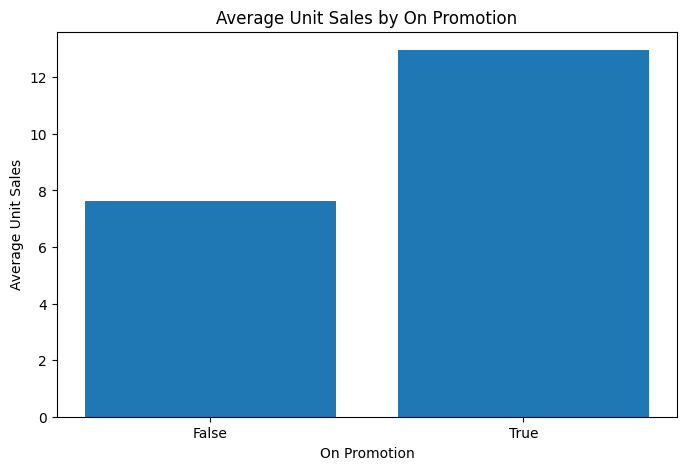

In [11]:
#to do: plot average unit_sales by onpromotion using barplot 
plt.figure(figsize=(8, 5))
avg_sales_onpromo = sample.groupby("onpromotion")["unit_sales"].mean().reset_index()
plt.bar(avg_sales_onpromo["onpromotion"].astype(str), avg_sales_onpromo["unit_sales"])
plt.title("Average Unit Sales by On Promotion")
plt.xlabel("On Promotion")
plt.ylabel("Average Unit Sales")
plt.show()

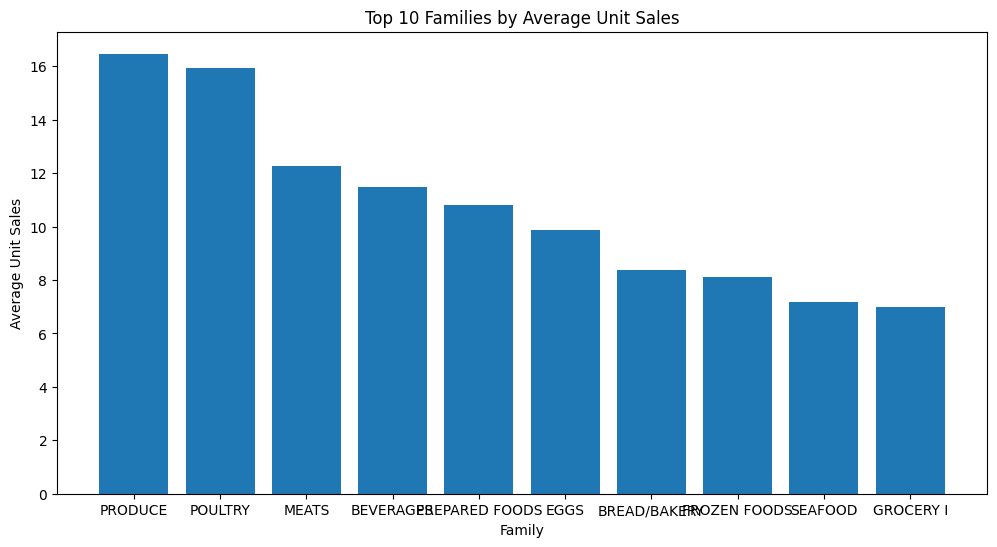

In [12]:
#to do: plot average unit_sales by family using barplot 
plt.figure(figsize=(12, 6))
avg_sales_family = sample.groupby("family")["unit_sales"].mean().reset_index()
avg_sales_family = avg_sales_family.sort_values(by="unit_sales", ascending=False).head(10)
plt.bar(avg_sales_family["family"], avg_sales_family["unit_sales"])
plt.title("Top 10 Families by Average Unit Sales")
plt.xlabel("Family")
plt.ylabel("Average Unit Sales")
plt.show()


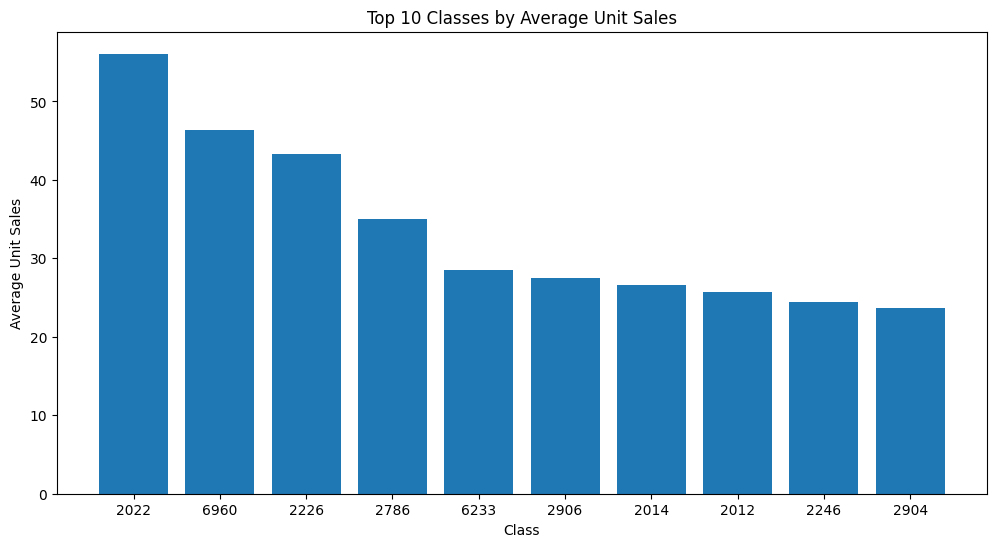

In [13]:
#to do: plot average unit_sales by class using barplot 
plt.figure(figsize=(12, 6))
avg_sales_class = sample.groupby("class")["unit_sales"].mean().reset_index()
avg_sales_class = avg_sales_class.sort_values(by="unit_sales", ascending=False).head(10)
plt.bar(avg_sales_class["class"].astype(str), avg_sales_class["unit_sales"])
plt.title("Top 10 Classes by Average Unit Sales")
plt.xlabel("Class")
plt.ylabel("Average Unit Sales")
plt.show()


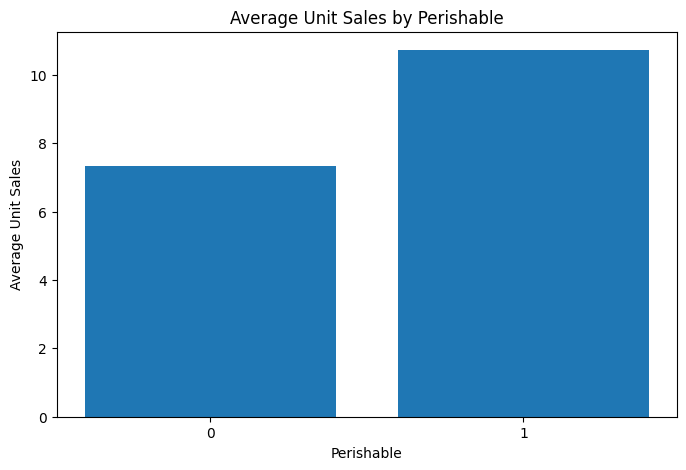

In [14]:
#to do: plot average unit_sales by perishable using barplot 
plt.figure(figsize=(8, 5))
avg_sales_perishable = sample.groupby("perishable")["unit_sales"].mean().reset_index()
plt.bar(avg_sales_perishable["perishable"].astype(str), avg_sales_perishable["unit_sales"])
plt.title("Average Unit Sales by Perishable")
plt.xlabel("Perishable")
plt.ylabel("Average Unit Sales")
plt.show()


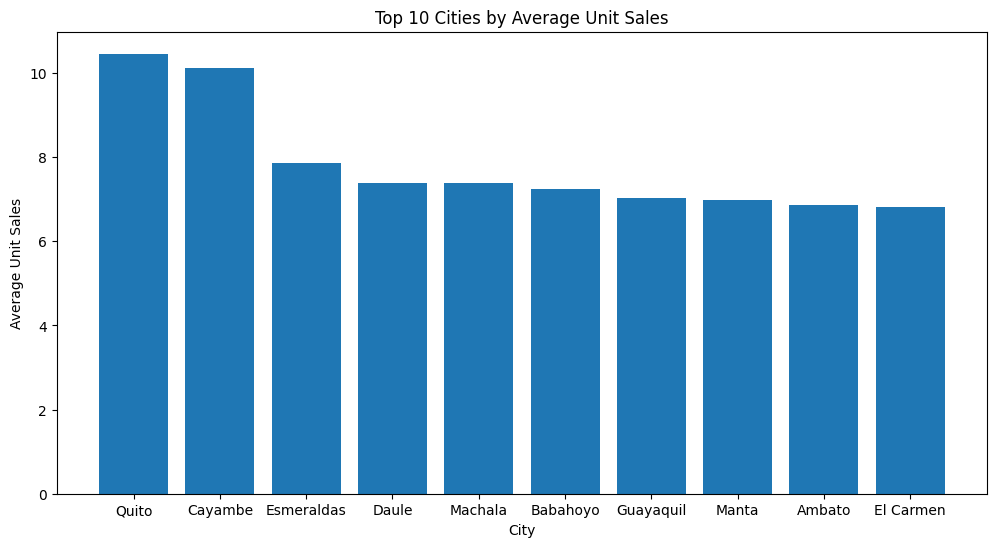

In [15]:
#to do: plot average unit_sales by city using barplot 
plt.figure(figsize=(12, 6))
avg_sales_city = sample.groupby("city")["unit_sales"].mean().reset_index()
avg_sales_city = avg_sales_city.sort_values(by="unit_sales", ascending=False).head(10)
plt.bar(avg_sales_city["city"], avg_sales_city["unit_sales"])
plt.title("Top 10 Cities by Average Unit Sales")
plt.xlabel("City")
plt.ylabel("Average Unit Sales")
plt.show()


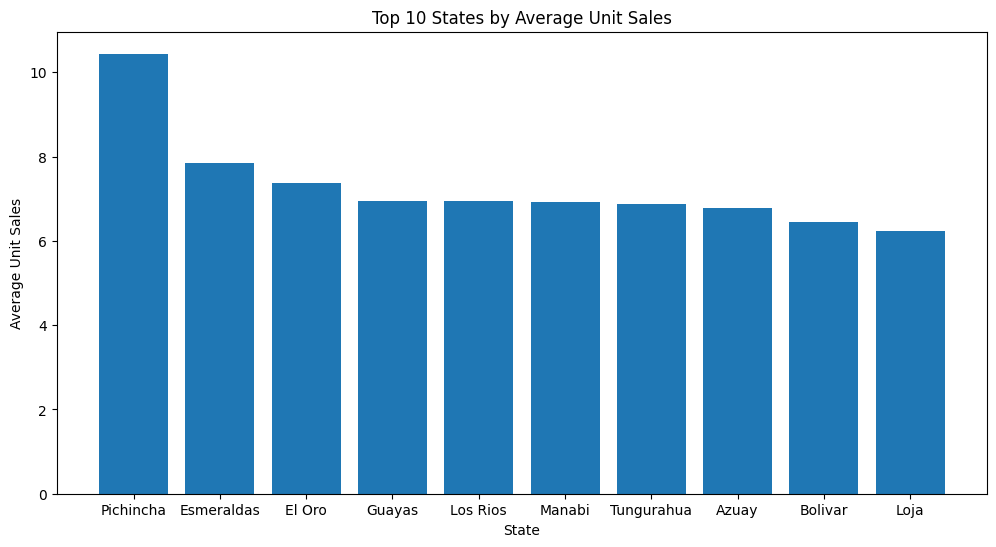

In [16]:
#to do: plot average unit_sales by state using barplot 
plt.figure(figsize=(12, 6))
avg_sales_state = sample.groupby("state")["unit_sales"].mean().reset_index()
avg_sales_state = avg_sales_state.sort_values(by="unit_sales", ascending=False).head(10)
plt.bar(avg_sales_state["state"], avg_sales_state["unit_sales"])
plt.title("Top 10 States by Average Unit Sales")
plt.xlabel("State")
plt.ylabel("Average Unit Sales")
plt.show()


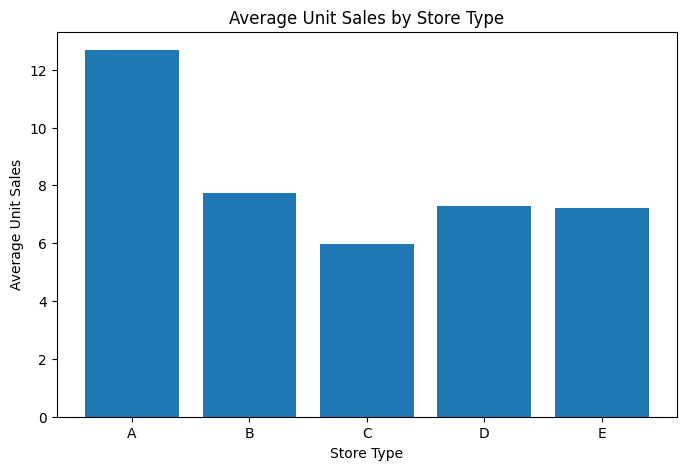

In [17]:
#to do: plot average unit_sales by type_x using barplot 
plt.figure(figsize=(8, 5))
avg_sales_type = sample.groupby("type_x")["unit_sales"].mean().reset_index()
plt.bar(avg_sales_type["type_x"], avg_sales_type["unit_sales"])
plt.title("Average Unit Sales by Store Type")
plt.xlabel("Store Type")
plt.ylabel("Average Unit Sales")
plt.show()


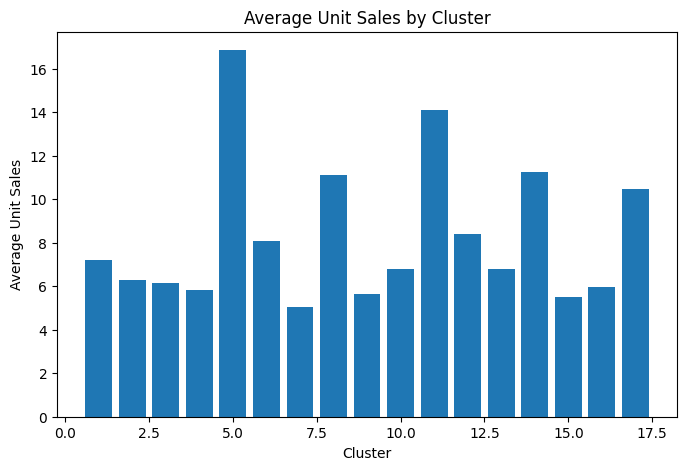

In [18]:
#to do: plot average unit_sales by cluster using barplot 
plt.figure(figsize=(8, 5))
avg_sales_cluster = sample.groupby("cluster")["unit_sales"].mean().reset_index()
plt.bar(avg_sales_cluster["cluster"], avg_sales_cluster["unit_sales"])
plt.title("Average Unit Sales by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Unit Sales")
plt.show()

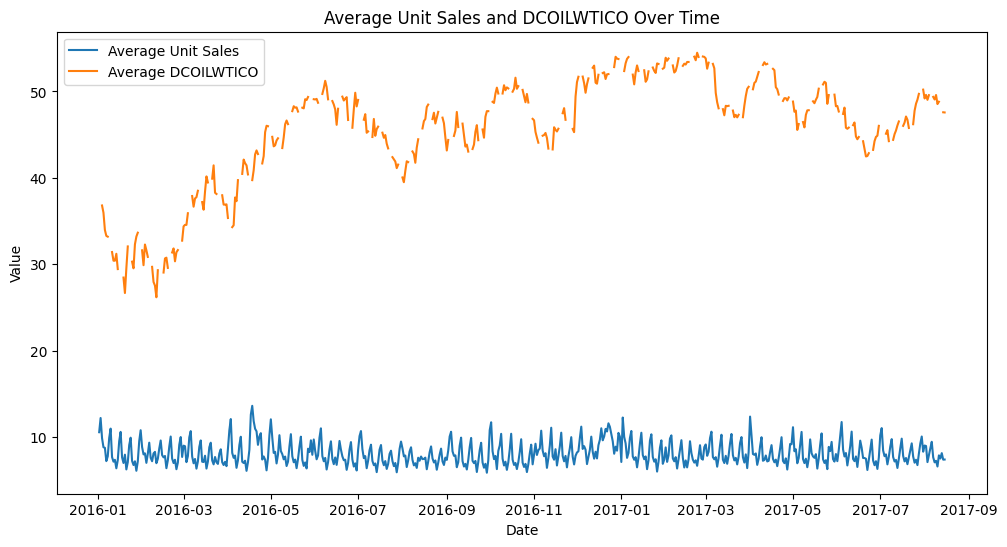

In [19]:
#to do: plot average unit_sales and dcoilwtico using time series plot 
plt.figure(figsize=(12, 6))
avg_sales_date = sample.groupby("date")["unit_sales"].mean().reset_index()
plt.plot(avg_sales_date["date"], avg_sales_date["unit_sales"], label="Average Unit Sales")
plt.plot(sample.groupby("date")["dcoilwtico"].mean().reset_index()["date"], sample.groupby("date")["dcoilwtico"].mean().reset_index()["dcoilwtico"], label="Average DCOILWTICO")
plt.title("Average Unit Sales and DCOILWTICO Over Time")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.show()

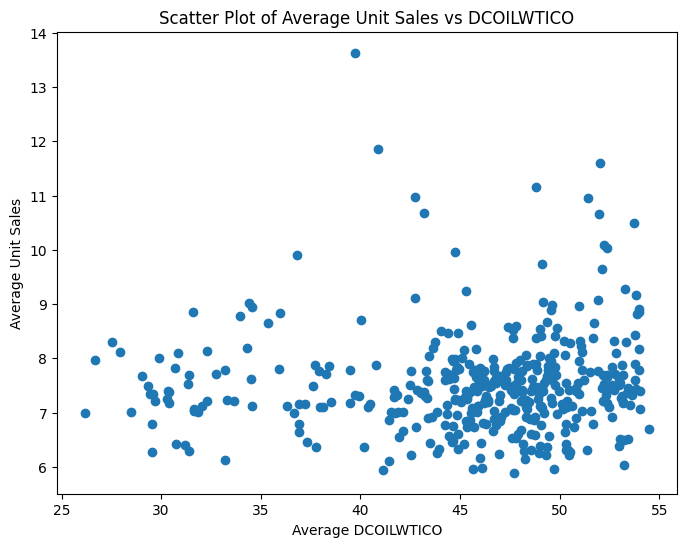

In [20]:
#to do: scatter plot average unit_sales and dcoilwtico
plt.figure(figsize=(8, 6))
avg_sales_dcoil = sample.groupby("date").agg({"unit_sales": "mean", "dcoilwtico": "mean"}).reset_index()
plt.scatter(avg_sales_dcoil["dcoilwtico"], avg_sales_dcoil["unit_sales"])
plt.title("Scatter Plot of Average Unit Sales vs DCOILWTICO")
plt.xlabel("Average DCOILWTICO")
plt.ylabel("Average Unit Sales")
plt.show()


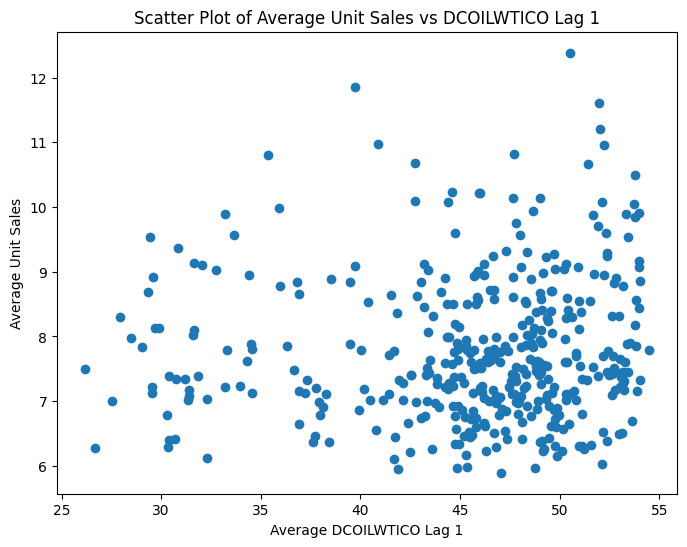

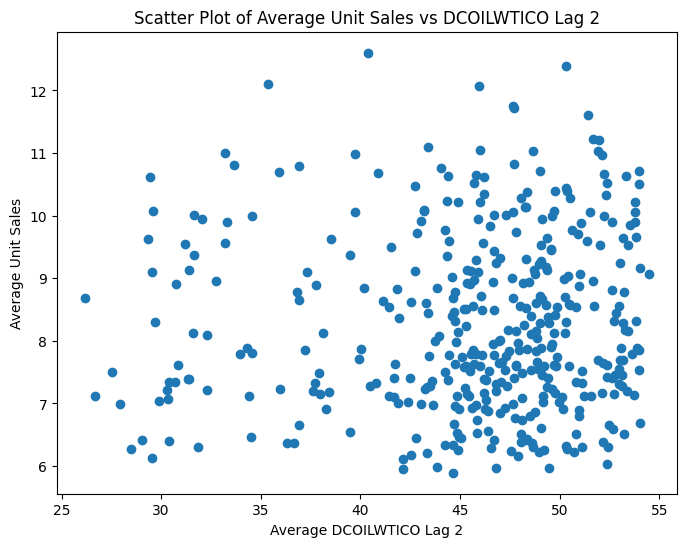

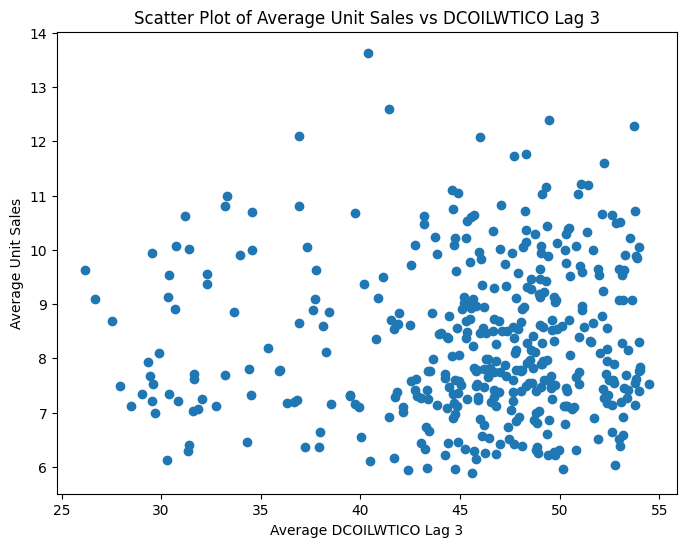

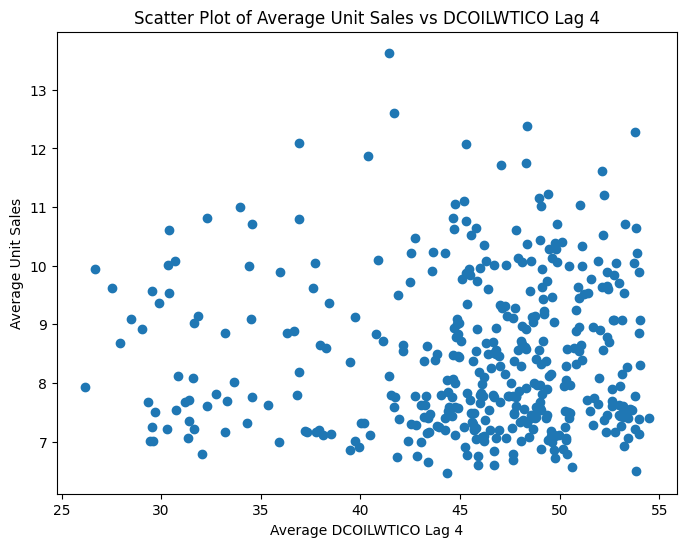

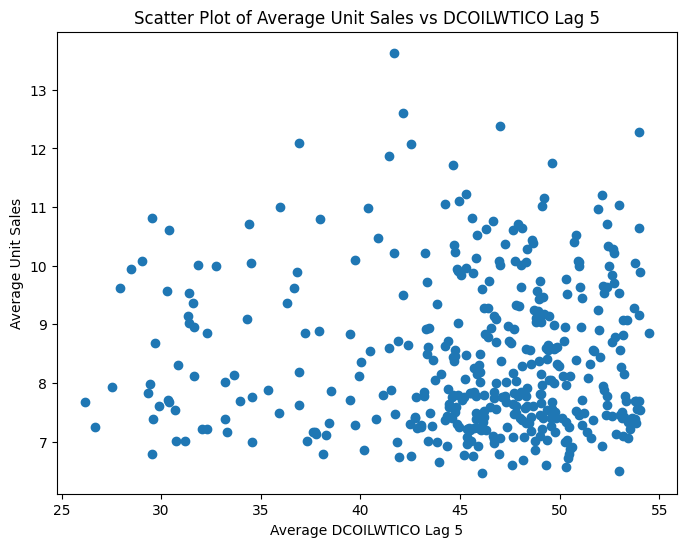

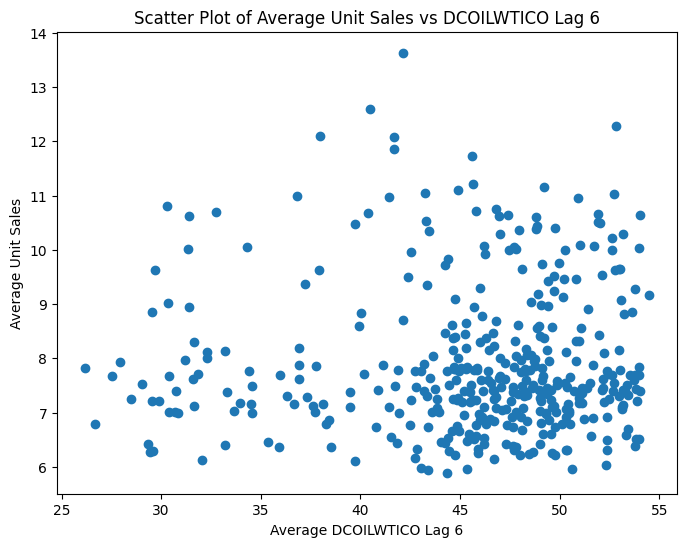

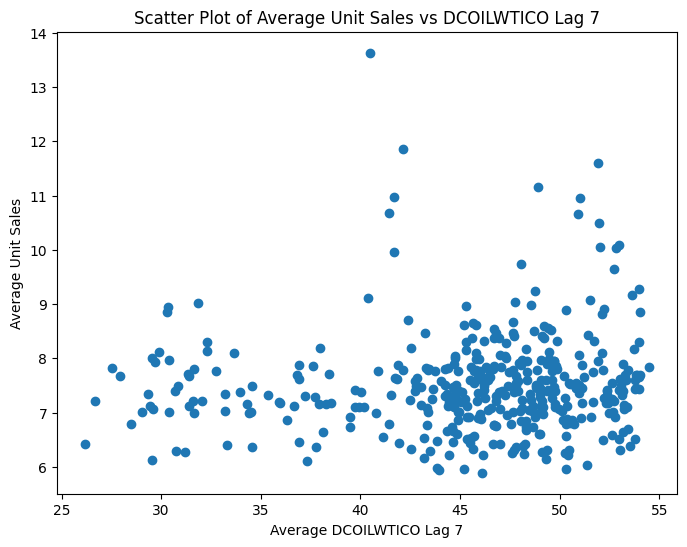

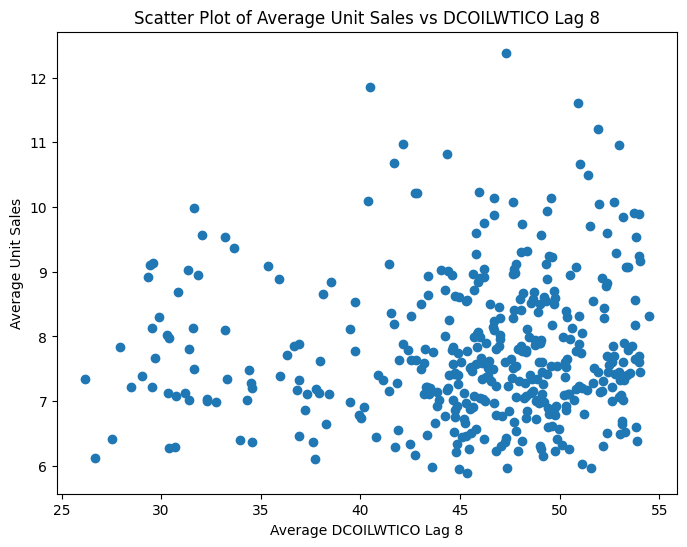

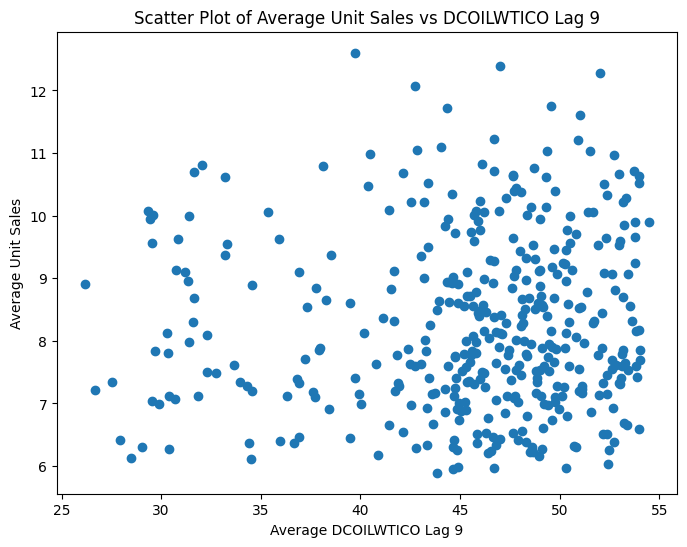

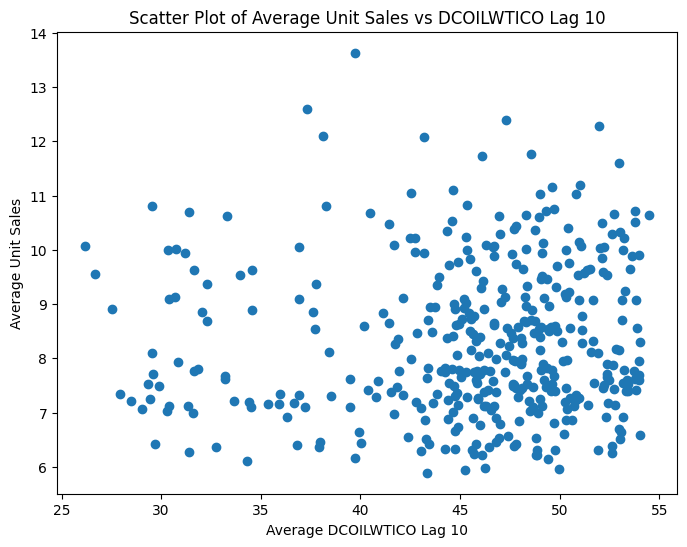

In [21]:
#to do: create 10 scatter plots with average unit_sales and lag 1 - 10 of dcoilwtico
for lag in range(1, 11):
    plt.figure(figsize=(8, 6))
    avg_sales_dcoil_lag = sample.groupby("date").agg({"unit_sales": "mean", "dcoilwtico": "mean"}).reset_index()
    avg_sales_dcoil_lag["dcoilwtico_lag"] = avg_sales_dcoil_lag["dcoilwtico"].shift(lag)
    plt.scatter(avg_sales_dcoil_lag["dcoilwtico_lag"], avg_sales_dcoil_lag["unit_sales"])
    plt.title(f"Scatter Plot of Average Unit Sales vs DCOILWTICO Lag {lag}")
    plt.xlabel(f"Average DCOILWTICO Lag {lag}")
    plt.ylabel("Average Unit Sales")
    plt.show()


Lag 7 seems to have exp correlation 

In [22]:
#to do: replace missing values of type_y with 'Unknown'
sample.loc[:, "type_y"] = sample["type_y"].fillna("Unknown")

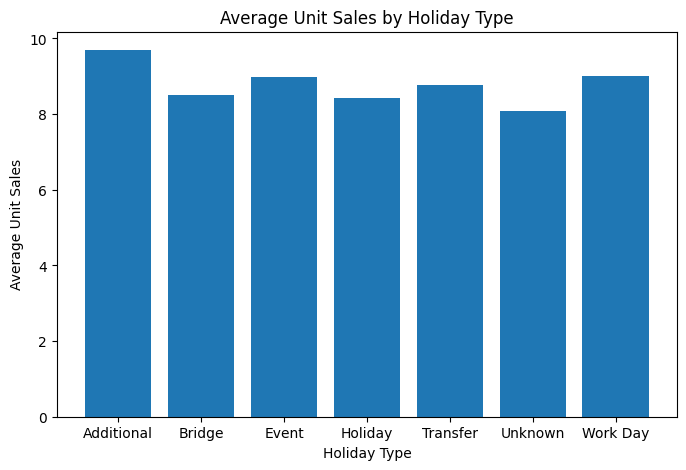

In [23]:
#to do: plot average unit_sales by type_y using barplot 
plt.figure(figsize=(8, 5))
avg_sales_type_y = sample.groupby("type_y")["unit_sales"].mean().reset_index()
plt.bar(avg_sales_type_y["type_y"], avg_sales_type_y["unit_sales"])
plt.title("Average Unit Sales by Holiday Type")
plt.xlabel("Holiday Type")
plt.ylabel("Average Unit Sales")
plt.show()


In [24]:
#to do: give basic info of type_y
print(sample["type_y"].value_counts())
print(sample["type_y"].describe())


type_y
Unknown       49213965
Holiday        5754432
Event          3394219
Additional     1284287
Transfer        728627
Work Day        103086
Bridge          100980
Name: count, dtype: int64
count     60579596
unique           7
top        Unknown
freq      49213965
Name: type_y, dtype: object


## Feature engineering
 

In [25]:
sample['lag_1'] = sample.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
sample['lag_7'] = sample.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)

/var/folders/mg/hcjfqqxj19n3y9wkwzpkcnvw0000gn/T/ipykernel_6056/3681513483.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['lag_1'] = sample.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(1)
/var/folders/mg/hcjfqqxj19n3y9wkwzpkcnvw0000gn/T/ipykernel_6056/3681513483.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['lag_7'] = sample.groupby(['store_nbr', 'item_nbr'])['unit_sales'].shift(7)


In [26]:
sample['day_of_week'] = sample['date'].dt.dayofweek
sample['day_of_month'] = sample['date'].dt.day
sample['week_of_year'] = sample['date'].dt.isocalendar().week

sample['month'] = sample['date'].dt.month
sample['month_sin'] = np.sin(2 * np.pi * sample['month'] / 12)
sample['month_cos'] = np.cos(2 * np.pi * sample['month'] / 12)

print(sample.head())

/var/folders/mg/hcjfqqxj19n3y9wkwzpkcnvw0000gn/T/ipykernel_6056/2494286408.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['day_of_week'] = sample['date'].dt.dayofweek
/var/folders/mg/hcjfqqxj19n3y9wkwzpkcnvw0000gn/T/ipykernel_6056/2494286408.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['day_of_month'] = sample['date'].dt.day
/var/folders/mg/hcjfqqxj19n3y9wkwzpkcnvw0000gn/T/ipykernel_6056/2494286408.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

                id       date  store_nbr  item_nbr  unit_sales onpromotion  \
67390661  66460626 2016-01-02          1    103520         1.0        True   
67390662  66460627 2016-01-02          1    105574         2.0       False   
67390663  66460628 2016-01-02          1    105575        10.0       False   
67390664  66460629 2016-01-02          1    105577        11.0       False   
67390665  66460630 2016-01-02          1    106716         2.0       False   

             family  class  perishable   city  ... description transferred  \
67390661  GROCERY I   1028           0  Quito  ...         NaN         NaN   
67390662  GROCERY I   1045           0  Quito  ...         NaN         NaN   
67390663  GROCERY I   1045           0  Quito  ...         NaN         NaN   
67390664  GROCERY I   1045           0  Quito  ...         NaN         NaN   
67390665  GROCERY I   1032           0  Quito  ...         NaN         NaN   

          lag_1  lag_7 day_of_week day_of_month week_of_year m

/var/folders/mg/hcjfqqxj19n3y9wkwzpkcnvw0000gn/T/ipykernel_6056/2494286408.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['month_cos'] = np.cos(2 * np.pi * sample['month'] / 12)


In [27]:
# features and target
features_v1n = ['month_sin', 'month_cos', 'lag_1', 'lag_7', 'day_of_week', 'day_of_month', 'week_of_year']
target_v1n = 'unit_sales' 

## The model v1.no_exogenous (v1n)

In [28]:
cat_cols = ['onpromotion', 'family', 'city', 'state', 'type_x', 'type_y']

sample = sample.copy()
for c in cat_cols:
    sample[f"{c}_cat"] = sample[c].astype('category').cat.codes.astype('int32')


print(sample.info())

<class 'pandas.core.frame.DataFrame'>
Index: 60579596 entries, 67390661 to 127970256
Data columns (total 33 columns):
 #   Column           Dtype         
---  ------           -----         
 0   id               int64         
 1   date             datetime64[ns]
 2   store_nbr        int64         
 3   item_nbr         int64         
 4   unit_sales       float64       
 5   onpromotion      object        
 6   family           object        
 7   class            int64         
 8   perishable       int64         
 9   city             object        
 10  state            object        
 11  type_x           object        
 12  cluster          int64         
 13  dcoilwtico       float64       
 14  type_y           object        
 15  locale           object        
 16  locale_name      object        
 17  description      object        
 18  transferred      object        
 19  lag_1            float64       
 20  lag_7            float64       
 21  day_of_week      int32    

In [29]:
# create train and test
sample = sample.copy()
sample['date'] = pd.to_datetime(sample['date'])
sample = sample.sort_values('date')

cutoff_date = sample['date'].max() - pd.Timedelta(days=90-1)  # last 90 calendar days
test_s  = sample[sample['date'] >= cutoff_date]
train_s = sample[sample['date'] <  cutoff_date]


In [30]:

X_train_s_v1n, y_train_s_v1n = train_s[features_v1n], train_s[target_v1n]
X_test_s_v1n, y_test_s_v1n = test_s[features_v1n], test_s[target_v1n]

In [31]:
model_v1n = XGBRegressor(
 n_estimators=2000, learning_rate=0.03,
    max_depth=5, subsample=0.8, colsample_bytree=0.8,
    min_child_weight=2, max_bin=256,
    tree_method="hist", n_jobs=4, random_state=42
)

model_v1n.fit(X_train_s_v1n, y_train_s_v1n)

y_train_pred_v1n = model_v1n.predict(X_train_s_v1n)
y_test_pred_v1n = model_v1n.predict(X_test_s_v1n) 

r2_train_v1n = r2_score(y_train_s_v1n, y_train_pred_v1n)
r2_test_v1n = r2_score(y_test_s_v1n, y_test_pred_v1n)

print(f"R2 train: {r2_train_v1n:.4f}")
print(f"R2 test : {r2_test_v1n:.4f}")

R2 train: 0.3671
R2 test : 0.3578


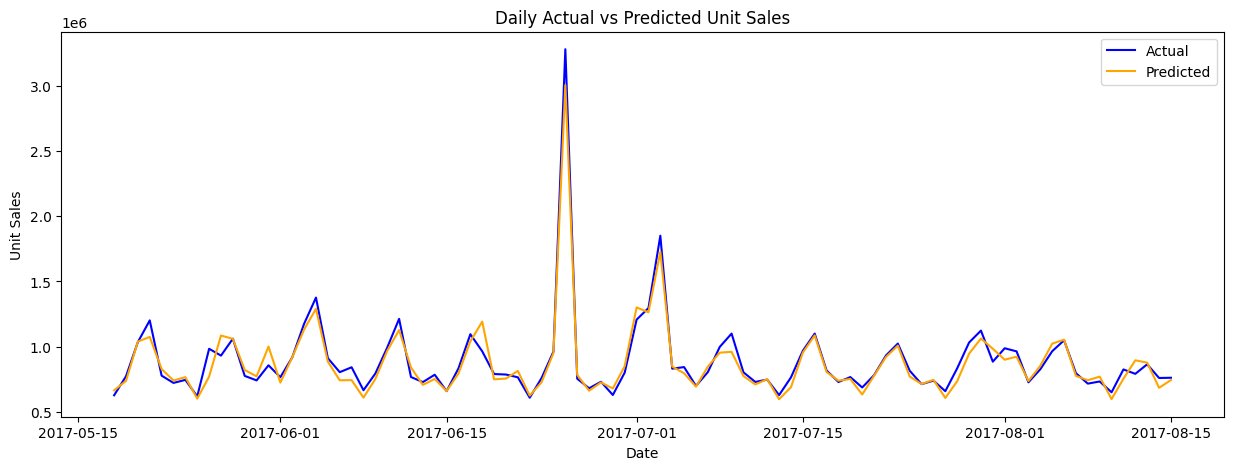

In [32]:
#to do: aggregate unit_sales and y_test_pred to daily values using sum and plot actual vs predicted for test set
daily_actual = test_s.groupby('date')[target_v1n].sum()
daily_predicted_v1n = pd.Series(y_test_pred_v1n, index=test_s.index).groupby(test_s['date']).sum()  
plt.figure(figsize=(15, 5))
plt.plot(daily_actual.index, daily_actual.values, label='Actual', color='blue')
plt.plot(daily_predicted_v1n.index, daily_predicted_v1n.values, label='Predicted', color='orange')
plt.title('Daily Actual vs Predicted Unit Sales')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.show()


In [33]:
#to do: claculate r2 on daily_actual vs daily_predicted
r2_daily_v1n = r2_score(daily_actual.values, daily_predicted_v1n.values)
print(f"R2 on daily aggregated values: {r2_daily_v1n:.4f}")

R2 on daily aggregated values: 0.9514


In [34]:
sample.columns

Index(['id', 'date', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'family', 'class', 'perishable', 'city', 'state', 'type_x', 'cluster',
       'dcoilwtico', 'type_y', 'locale', 'locale_name', 'description',
       'transferred', 'lag_1', 'lag_7', 'day_of_week', 'day_of_month',
       'week_of_year', 'month', 'month_sin', 'month_cos', 'onpromotion_cat',
       'family_cat', 'city_cat', 'state_cat', 'type_x_cat', 'type_y_cat'],
      dtype='object')

##The model v1.exogenous (v1e)

In [35]:
# # build daily avg oil series and lag by 7 days
# oil_daily = (
#     oil.assign(date=pd.to_datetime(oil['date']))
#        .groupby('date', as_index=False)['dcoilwtico']
#        .mean()
# )
# oil_daily['dcoilwtico_lag7'] = oil_daily['dcoilwtico'].shift(7)

# # merge into sample on date
# sample = sample.copy()
# sample['date'] = pd.to_datetime(sample['date'])
# sample = sample.merge(oil_daily[['date', 'dcoilwtico_lag7']], on='date', how='left')
# print(sample[['date', 'dcoilwtico','dcoilwtico_lag7']].head())

In [36]:

features_v1e = ['month_sin', 'month_cos', 'lag_1', 'lag_7', 'day_of_week', 'day_of_month', 'week_of_year', 
        'store_nbr', 'item_nbr', 'onpromotion_cat',
        'family_cat', 'class', 'perishable', 'city_cat', 
        'state_cat', 'type_x_cat', 'cluster', 'type_y_cat']


target_v1e = 'unit_sales' 

X_train_s_v1e, y_train_s_v1e = train_s[features_v1e], train_s[target_v1e]
X_test_s_v1e, y_test_s_v1e = test_s[features_v1e], test_s[target_v1e]

In [37]:
X_train_s_v1e.dtypes

month_sin          float64
month_cos          float64
lag_1              float64
lag_7              float64
day_of_week          int32
day_of_month         int32
week_of_year        UInt32
store_nbr            int64
item_nbr             int64
onpromotion_cat      int32
family_cat           int32
class                int64
perishable           int64
city_cat             int32
state_cat            int32
type_x_cat           int32
cluster              int64
type_y_cat           int32
dtype: object

In [38]:
model_v1e = XGBRegressor(
 n_estimators=2000, learning_rate=0.03,
    max_depth=5, subsample=0.8, colsample_bytree=0.8,
    min_child_weight=2, max_bin=256,
    tree_method="hist", n_jobs=4, random_state=42
)

model_v1e.fit(X_train_s_v1e, y_train_s_v1e)

y_train_pred_v1e = model_v1e.predict(X_train_s_v1e)
y_test_pred_v1e = model_v1e.predict(X_test_s_v1e) 

r2_train_v1e = r2_score(y_train_s_v1e, y_train_pred_v1e)
r2_test_v1e = r2_score(y_test_s_v1e, y_test_pred_v1e)

print(f"R2 train: {r2_train_v1e:.4f}")
print(f"R2 test : {r2_test_v1e:.4f}")

R2 train: 0.6008
R2 test : 0.2288


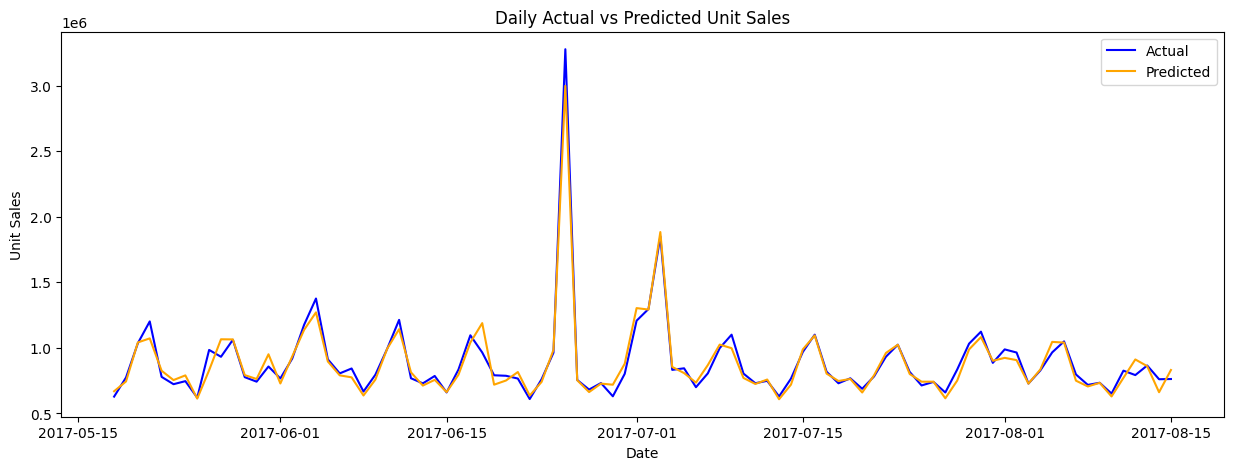

In [39]:
daily_actual = test_s.groupby('date')[target_v1e].sum()
daily_predicted_v1e = pd.Series(y_test_pred_v1e, index=test_s.index).groupby(test_s['date']).sum()  
plt.figure(figsize=(15, 5))
plt.plot(daily_actual.index, daily_actual.values, label='Actual', color='blue')
plt.plot(daily_predicted_v1e.index, daily_predicted_v1e.values, label='Predicted', color='orange')
plt.title('Daily Actual vs Predicted Unit Sales')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.show()


In [40]:
r2_daily_v1e = r2_score(daily_actual.values, daily_predicted_v1e.values)
print(f"R2 on daily aggregated values: {r2_daily_v1e:.4f}")

R2 on daily aggregated values: 0.9604


##The model: v2 regularised (v2r)

In [42]:
model_v2r = XGBRegressor(
    n_estimators=4000,         # allow early stopping to pick the best round
    learning_rate=0.02,        # smaller step size
    max_depth=4,               # shallower trees
    min_child_weight=5,        # require more samples per leaf
    subsample=0.7,             # row subsampling
    colsample_bytree=0.7,      # feature subsampling
    gamma=0.1,                 # minimum loss reduction to split
    reg_alpha=0.1,             # L1 regularization
    reg_lambda=1.5,            # L2 regularization
    max_bin=256,
    tree_method="hist",
    n_jobs=4,
    random_state=42,
)

model_v2r.fit(X_train_s_v1e, y_train_s_v1e)

y_train_pred_v2r = model_v2r.predict(X_train_s_v1e)
y_test_pred_v2r = model_v2r.predict(X_test_s_v1e) 

r2_train_v2r = r2_score(y_train_s_v1e, y_train_pred_v2r)
r2_test_v2r = r2_score(y_test_s_v1e, y_test_pred_v2r)

print(f"R2 train: {r2_train_v2r:.4f}")
print(f"R2 test : {r2_test_v2r:.4f}")

R2 train: 0.4889
R2 test : 0.3056


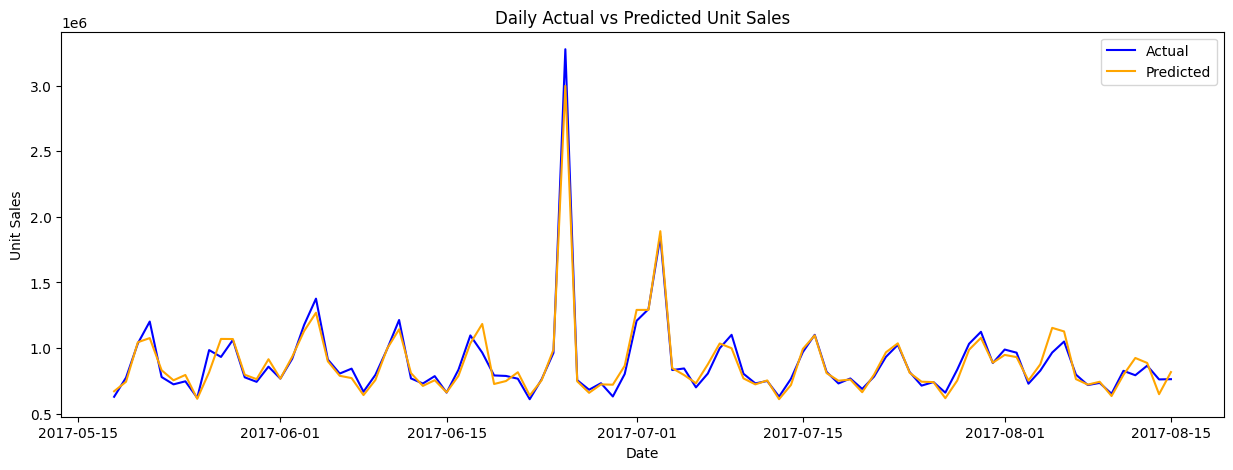

In [43]:
#aily_actual = test_s.groupby('date')[target_v1e].sum()
daily_predicted_v2r = pd.Series(y_test_pred_v2r, index=test_s.index).groupby(test_s['date']).sum()  
plt.figure(figsize=(15, 5))
plt.plot(daily_actual.index, daily_actual.values, label='Actual', color='blue')
plt.plot(daily_predicted_v2r.index, daily_predicted_v2r.values, label='Predicted', color='orange')
plt.title('Daily Actual vs Predicted Unit Sales')
plt.xlabel('Date')
plt.ylabel('Unit Sales')
plt.legend()
plt.show()


In [44]:
r2_daily_v2r = r2_score(daily_actual.values, daily_predicted_v2r.values)
print(f"R2 on daily aggregated values: {r2_daily_v2r:.4f}")

R2 on daily aggregated values: 0.9569


In [48]:

# ---------------------------------------------------
# 1. Define NWRMSLE (Kaggle Favorita metric)
# ---------------------------------------------------

def nwrmsle(y_true, y_pred, weights=None):
    """
    Normalized Weighted Root Mean Squared Logarithmic Error (NWRMSLE)

    y_true  : array-like of true unit_sales
    y_pred  : array-like of predicted unit_sales
    weights : optional array of same length with per-row weights
              (perishable items = 1.25, others = 1.0)
    """

    y_true = np.asarray(y_true, dtype=float)
    y_pred = np.asarray(y_pred, dtype=float)

    # Avoid negative and NaN values
    y_true = np.maximum(0, np.nan_to_num(y_true))
    y_pred = np.maximum(0, np.nan_to_num(y_pred))

    log_true = np.log1p(y_true)
    log_pred = np.log1p(y_pred)

    sq_error = (log_pred - log_true) ** 2

    if weights is None:
        return np.sqrt(np.mean(sq_error))
    else:
        weights = np.asarray(weights, dtype=float)
        return np.sqrt(np.average(sq_error, weights=weights))


# ---------------------------------------------------
# 2. Are your predictions in log-space or real-space?
# ---------------------------------------------------
# If you trained the model on log1p(unit_sales), set this to True.
# If you trained directly on unit_sales, leave as False.

PRED_IN_LOG_SPACE = False  # <-- CHANGE to True if your model predicts log1p(sales)

if PRED_IN_LOG_SPACE:
    y_train_pred_for_metric = np.expm1(y_train_pred_v2r)
    y_test_pred_for_metric  = np.expm1(y_test_pred_v2r)
else:
    y_train_pred_for_metric = y_train_pred_v2r
    y_test_pred_for_metric  = y_test_pred_v2r


# ---------------------------------------------------
# 3. Define Kaggle weights from `perishable` column
# ---------------------------------------------------
# This assumes X_train_s_v1e / X_test_s_v1e contain a `perishable` column
# with values 0 (non-perishable) or 1 (perishable).

weights_train = np.where(X_train_s_v1e["perishable"] == 1, 1.25, 1.0)
weights_test  = np.where(X_test_s_v1e["perishable"] == 1, 1.25, 1.0)


# ---------------------------------------------------
# 4. Compute NWRMSLE (unweighted + weighted)
# ---------------------------------------------------

# Unweighted
nwrmsle_train = nwrmsle(y_train_s_v1e, y_train_pred_for_metric)
nwrmsle_test  = nwrmsle(y_test_s_v1e,  y_test_pred_for_metric)

print(f"Unweighted NWRMSLE - train: {nwrmsle_train:.5f}")
print(f"Unweighted NWRMSLE - test : {nwrmsle_test:.5f}")

# Kaggle-style weighted
nwrmsle_train_w = nwrmsle(y_train_s_v1e, y_train_pred_for_metric, weights=weights_train)
nwrmsle_test_w  = nwrmsle(y_test_s_v1e,  y_test_pred_for_metric,  weights=weights_test)

print(f"\nWeighted NWRMSLE (Kaggle) - train: {nwrmsle_train_w:.5f}")
print(f"Weighted NWRMSLE (Kaggle) - test : {nwrmsle_test_w:.5f}")

print("\n(Top Kaggle solutions are roughly around ~0.52–0.54 NWRMSLE; lower is better.)")

Unweighted NWRMSLE - train: 0.57069
Unweighted NWRMSLE - test : 0.57158

Weighted NWRMSLE (Kaggle) - train: 0.56989
Weighted NWRMSLE (Kaggle) - test : 0.57085

(Top Kaggle solutions are roughly around ~0.52–0.54 NWRMSLE; lower is better.)
